* ganho
* filtro
* intervalo entre traços
---

* ajuste de hipérbole
* processamento básico com os dados da Milene
* CMP

---

* usar arquivos de dados em formato ASCII
* fazer recurso para visalização de traços individuais com o mesmo layout do notebook de grav/mag
* fazer recurso para visualização de espectro antes e depois da filtragem

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.signal import detrend
from scipy.interpolate import interp1d

In [2]:
class radargrama():
    def __init__(self, fname):
    
        tabela = np.loadtxt(fname)
        self.nome = fname
        self.eixo_x = np.unique(tabela[:, 0])
        self.eixo_t = np.unique(tabela[:, 1]) * 1e-9
        self.dados = detrend(np.reshape(tabela[:, 2], [len(self.eixo_x), len(self.eixo_t)]).T, axis=0)
        self.n_amostras, self.n_tracos = np.shape(self.dados)
   

    def ganho_exp(self, tmin=0.0, a=1.0, b=1.0, x=0.0, salva=False):
        
        it = np.abs(self.eixo_t - tmin).argmin()
        
        g_t = (a * np.exp(b * self.eixo_t[it:] * 1e7)).reshape([-1,1]) + 1
        g_t = np.repeat(g_t, self.n_tracos, axis=1)
        self.dados_aux = np.concatenate((self.dados[:it, :], self.dados[it:, :] * g_t), axis=0)
            
        if not salva:
            self.plota_aux(x, aux=g_t)
            
        else:
            self.dados = self.dados_aux
            self.plota_dados(x)
        
    
    
    def ganho_agc(self, tmin=0.0, janela=None, x=0.0, salva=False):
        pass

        
    def ganho_linear(self, tmin=0.0, a=1.0, x=0.0, salva=False):
        
        it = np.abs(self.eixo_t - tmin).argmin()
        
        g_aux = [0.0, a]
        t_aux = [self.eixo_t[it], self.eixo_t[-1]]

        gf = interp1d(t_aux, g_aux)
        g_t = gf(self.eixo_t[it:]).reshape([-1,1]) + 1
        g_t = np.repeat(g_t, self.n_tracos, axis=1)
        self.dados_aux = np.concatenate((self.dados[:it, :], self.dados[it:, :] * g_t), axis=0)
            
        if not salva:
            self.plota_aux(x, aux=g_t)
            
        else:
            self.dados = self.dados_aux
            self.plota_dados(x)

            
    def plota_dados(self, x=None):
        
        if x:
            i = np.abs(self.eixo_x - x).argmin()
        else:
            x = self.eixo_x[0]
            i = 0
        
        proporcao = (np.max(self.eixo_x) - np.min(self.eixo_x)) / (1e9*(np.max(self.eixo_t) - np.min(self.eixo_t)))
        
        fig = plt.figure(figsize=(15, 7))
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
        ax0 = plt.subplot(gs[0])
        ax0.imshow(self.dados / np.max(np.abs(self.dados)), extent=[self.eixo_x[0], self.eixo_x[-1], \
                                                                    self.eixo_t[-1]*1e9, self.eixo_t[0]*1e9], cmap='bwr_r')
        ax0.plot([x, x], [np.min(self.eixo_t)*1e9, np.max(self.eixo_t)*1e9], '--k', linewidth=1.0)
        ax0.set_title(self.nome, fontsize=14)
        ax0.set_xlabel('Distância (m)', fontsize=14)
        ax0.set_ylabel('Tempo (ns)', fontsize=14)
        ax0.set_aspect(proporcao)
        ax0.grid()
        
        ax1 = plt.subplot(gs[1])
        ax1.plot(self.dados[:, i] / np.max(np.abs(self.dados[:, i])), self.eixo_t*1e9)
        ax1.set_title('Traço em ' + str(x) + ' m', fontsize=14)
        ax1.set_xlabel('Amplitude normalizada', fontsize=14)
        ax1.set_ylabel('Tempo (ns)', fontsize=14)
        ax1.grid()
        ax1.set_ylim([np.min(self.eixo_t)*1e9, np.max(self.eixo_t)*1e9])
        ax1.set_xlim([-1.2, 1.2])
        ax1.invert_yaxis()
        
        plt.tight_layout()
        plt.show()
        
        

    def plota_aux(self, x=None, aux=None):

            if x:
                i = np.abs(self.eixo_x - x).argmin()
            else:
                x = self.eixo_x[0]
                i = 0

            proporcao = (np.max(self.eixo_x) - np.min(self.eixo_x)) / (1e9*(np.max(self.eixo_t) - np.min(self.eixo_t)))

            fig = plt.figure(figsize=(15, 7))
            gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
            ax0 = plt.subplot(gs[0])
            ax0.imshow(self.dados_aux / np.max(np.abs(self.dados_aux)), extent=[self.eixo_x[0], self.eixo_x[-1], \
                                                                        self.eixo_t[-1]*1e9, self.eixo_t[0]*1e9], cmap='bwr_r')
            ax0.plot([x, x], [np.min(self.eixo_t)*1e9, np.max(self.eixo_t)*1e9], '--k', linewidth=1.0)
            ax0.set_title(self.nome + ' (temporário)', fontsize=14)
            ax0.set_xlabel('Distância (m)', fontsize=14)
            ax0.set_ylabel('Tempo (ns)', fontsize=14)
            ax0.set_aspect(proporcao)
            ax0.grid()

            ax1 = plt.subplot(gs[1])
            ax1.plot(self.dados_aux[:, i] / np.max(np.abs(self.dados_aux[:, i])), self.eixo_t*1e9)
            ax1.set_title('Traço em ' + str(x) + ' m', fontsize=14)
            ax1.set_xlabel('Amplitude normalizada', fontsize=14)
            ax1.set_ylabel('Tempo (ns)', fontsize=14)
            ax1.grid()
            ax1.set_ylim([np.min(self.eixo_t)*1e9, np.max(self.eixo_t)*1e9])
            ax1.set_xlim([-1.2, 1.2])
            ax1.invert_yaxis()

            plt.tight_layout()
            plt.show()

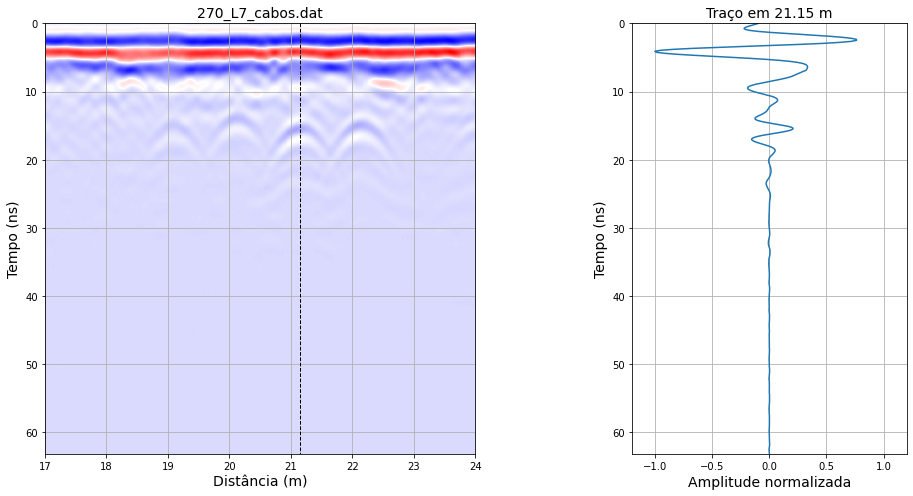

In [3]:
dados = radargrama('270_L7_cabos.dat')
dados.plota_dados(x=21.15)

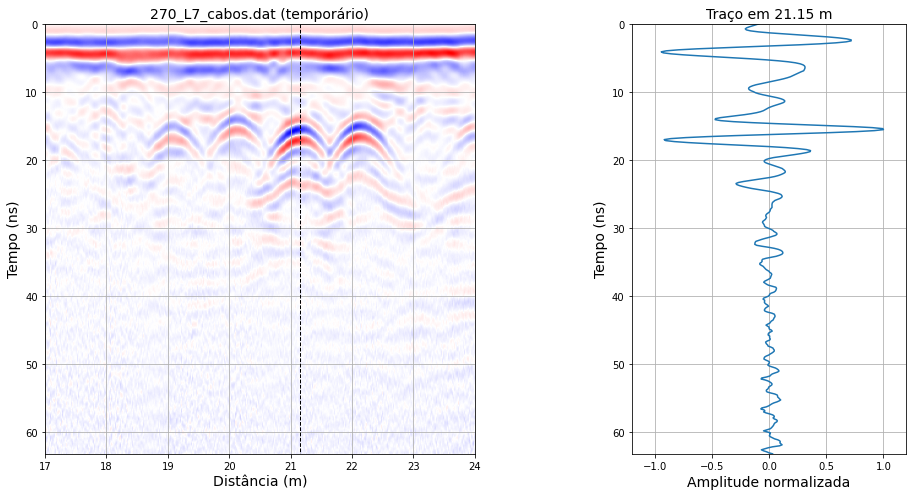

In [4]:
dados.ganho_linear(a=40.0, tmin=10e-9, x=21.15, salva=False)

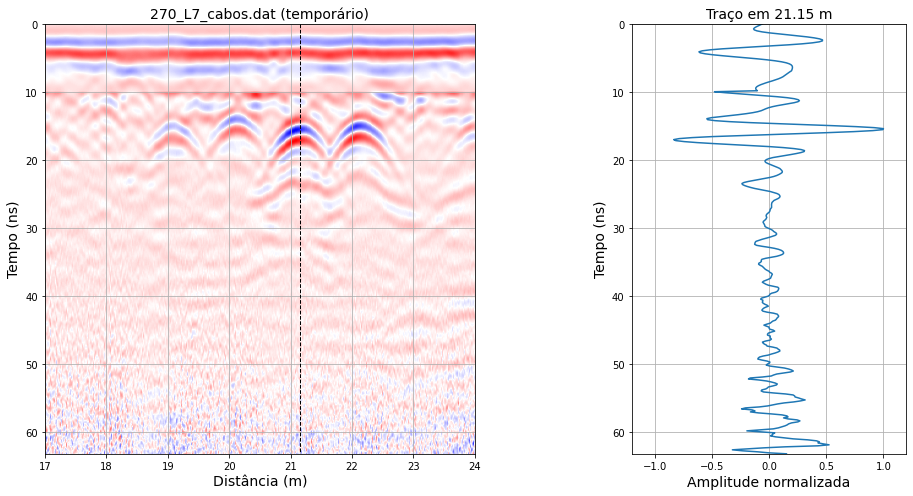

In [5]:
dados.ganho_exp(a=2.0, b=8.0, x=21.15, tmin=10e-9, salva=False)